# Prompt-Based Picking with ProPicker

In this notebook, we pick ribosomes in a single (defocus-only) tomogram contained in the EMPIAR-10988 dataset. To download the relevant parts of the dataset, you can use the `datasets/download_empiar10988.sh` script:

```bash
cd datasets
bash download_empiar10988.sh
```

**Note:** The dataset is large, so you might want to download it to a different location. In this case, you have to modify the `download_empiar10988.sh` script. 

**Note:** After downloading the dataset, make sure that the `EMPIAR10988_BASE_DIR` variable in `paths.py` points to the correct location.

In [1]:
import torch

from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

from clustering_and_picking import get_cluster_centroids_df
from evaluation import evaluate_picks, get_best_case_cluster_based_picking_performance
from paths import EMPIAR10988_BASE_DIR, TOMOTWIN_MODEL_FILE, PROPICKER_MODEL_FILE
from data.preparation_functions.prepare_empiar10988 import read_empiar10988_coords, empiar10988_ts_to_slice_of_interest
from data.utils import draw_balls
from inference import get_pred_locmap_dict
from model import ProPicker
from utils.mrctools import *

# disable warnings for chained assignments in pandas
pd.options.mode.chained_assignment = None  # default='warn'


## Load Data


/home/simon/ProPicker/utils/mrctools.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538456841/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  data = torch.from_numpy(mrc.data)


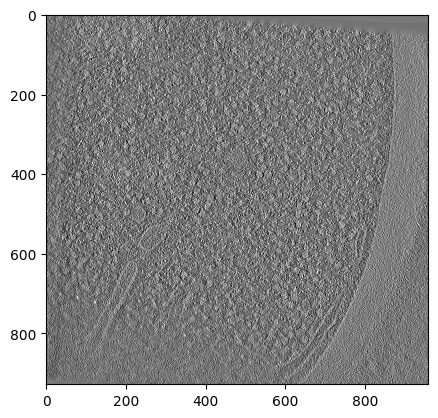

In [2]:
ts_id = "TS_030"

tomo_file = f"{EMPIAR10988_BASE_DIR}/tomograms/{ts_id}.rec"
ribo_coord_file = f"{EMPIAR10988_BASE_DIR}/particle_lists/{ts_id}_cyto_ribosomes.csv"

# tomograms contain large emtpy regions, so we only consider the interesting part
slice_of_interest = empiar10988_ts_to_slice_of_interest[ts_id]
tomo = -1 * load_mrc_data(tomo_file).float()
tomo = tomo[slice_of_interest].clone()


coords = read_empiar10988_coords(ribo_coord_file)
coords.Z -= slice_of_interest.start

plt.imshow(tomo[100], vmin=-2*tomo.std(), vmax=2*tomo.std(), cmap="gray")

## Picking a Single Ribosome as Prompt

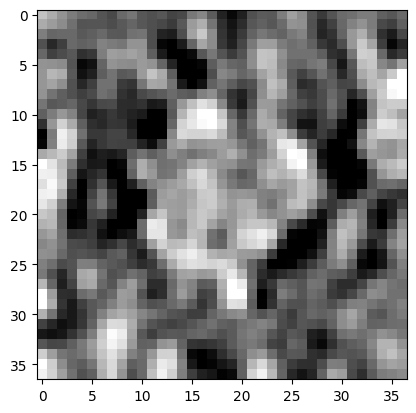

In [9]:
# extract all ribosomes as subtomos of shape (37, 37, 37); this shape is the one needed for the TomoTwin prompt encoder
all_ribo_subtomos = []
for coord in coords[["X", "Y", "Z"]].values.astype(int):
    x, y, z = coord
    subtomo = tomo[
        z-18:z+19,
        y-18:y+19,
        x-18:x+19
    ]
    # some ribosomes are at the edge of the tomogram, so we skip them
    if not subtomo.shape == (37, 37, 37):
        continue
    all_ribo_subtomos.append(subtomo)
    
# you can choose any of the ribo subtomos as prompt
prompt = all_ribo_subtomos[300]
prompt_subtomos_dict = {"cyto_ribosome": prompt}

# inspect prompt
prompt_filt = gaussian_filter(prompt, 1)
plt.imshow(prompt_filt[18], vmin=-2*prompt_filt.std(), vmax=2*prompt_filt.std(), cmap="gray")

## Applying the Conditional ProPicker Segmentation Model

Model config:
{'identifier': 'SiameseNet', 'network_config': {'output_channels': 32, 'dropout': 0.2, 'repeat_layers': 0, 'norm_name': 'GroupNorm', 'norm_kwargs': {'num_groups': 64, 'num_channels': 1024}, 'gem_pooling_p': 0}, 'train_config': {'loss': 'TripletLoss', 'tl_margin': 0.539, 'miner': True, 'miner_margin': 0.734, 'learning_rate': 5.945e-05, 'optimizer': 'Adam', 'weight_decay': 0, 'batchsize': 35, 'patience': 50, 'aug_train_shift_distance': 2}, 'distance': 'COSINE'}
Successfully loaded model weights


Inference (1 prompts): 100%|██████████| 381/381 [04:46<00:00,  1.33it/s]


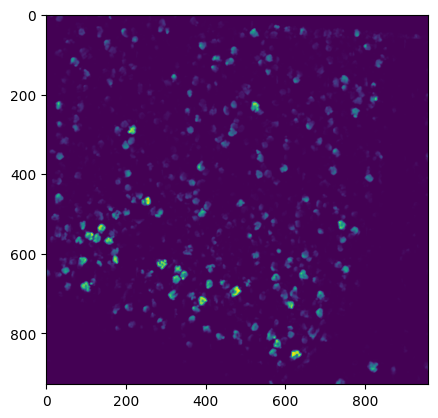

In [11]:
device = "cuda:3"

model = ProPicker.load_from_checkpoint(PROPICKER_MODEL_FILE, map_location="cpu").to(device)
model = model.to(device).eval()
model.freeze()
pred_locmap_dict = get_pred_locmap_dict(
    model, 
    tomo, 
    prompt_subtomos_dict=prompt_subtomos_dict, 
    tomotwin_model_file=TOMOTWIN_MODEL_FILE,  # tomotwin encoder is used to embed prompts in prompt_subtomos_dict
    subtomo_size=64,  # propicker processes the tomogram in subtomos of this size 
    subtomo_overlap=32,  # overlap of the subtomos, you can also reduce this
    batch_size=16,
    mean_pool_locmaps=0,  # you can use this to blur the model outputs, which can help with clustering and may remove some false positives; for crowded tomos such as EMPIAR10988, this is not recommended as it may lead to overlapping particle clusters
)

plt.imshow(pred_locmap_dict["cyto_ribosome"][100])

## Cluster-Based Picking

Apply thresholding and clustering to the ProPicker segmentation map to pick ribosomes. By tuning the hyperparameters for cluster-based picking, i.e. `binarization_threshold`, `min_cluster_size` and `max_cluster_size`, we can trade off precision and recall:
- `binarization_threshold`: The threshold for binarizing the ProPicker segmentation map. A smaller threshold will result in large clusters and higher recall, whereas a larger threshold will result in smaller clusters and higher precision. You can tune this such that the binarized locmap segments the particles well.
- `min_cluster_size`, `max_cluster_size`: We discard clusters with fewer than `min_cluster_size` or more than `max_cluster_size` particles. These parameters can be used to filter out false positives (improve precision), or to enforce a certain size distribution of the picked particles. If you choose a large `binarization_threshold`, you typically have to decrease `min_cluster_size` and `max_cluster_size` to pick enough particles.

In [39]:
binarization_thresh = 0.25  
binary_locmap = pred_locmap_dict["cyto_ribosome"] > binarization_thresh
# apply clustering to thresholded locmap
cluster_centroids = get_cluster_centroids_df(binary_locmap)
print(f"Number of clusters: {len(cluster_centroids)}")
print(cluster_centroids.head(5))

Number of clusters: 1818
       X     Y    Z  size
0  724.0  39.0  3.0   808
1  747.0  38.0  1.0   333
2  826.0  40.0  0.0     2
3  700.0  45.0  8.0  2008
4  785.0  45.0  5.0  1013


In [41]:
# you can choose the cluster sizes based on particle sizes or using statistics of the cluster sizes, here we use the former and choose the cluster sizes based on the volume of a sphere with radius 20 voxels which is approximately the size of a ribosome
ball_volume = 4/3 * torch.pi * (24/2)**3  
min_cluster_size = 0.1 * ball_volume  
max_cluster_size = 1.2 * ball_volume 
# discard small and large clusters (cluster size is in voxels)
cluster_centroids_filt = cluster_centroids[
    (min_cluster_size <= cluster_centroids["size"]) & (cluster_centroids["size"] <= max_cluster_size)
]
print(f"Number of clusters: {len(cluster_centroids_filt)}")
print(cluster_centroids_filt.head(5))

Number of clusters: 767
       X     Y     Z  size
0  724.0  39.0   3.0   808
3  700.0  45.0   8.0  2008
4  785.0  45.0   5.0  1013
5  802.0  44.0  11.0  1852
6  847.0  47.0   6.0  1047


## Visualize Picked Ribosomes

Drawing balls: 100%|██████████| 767/767 [00:32<00:00, 23.46it/s]


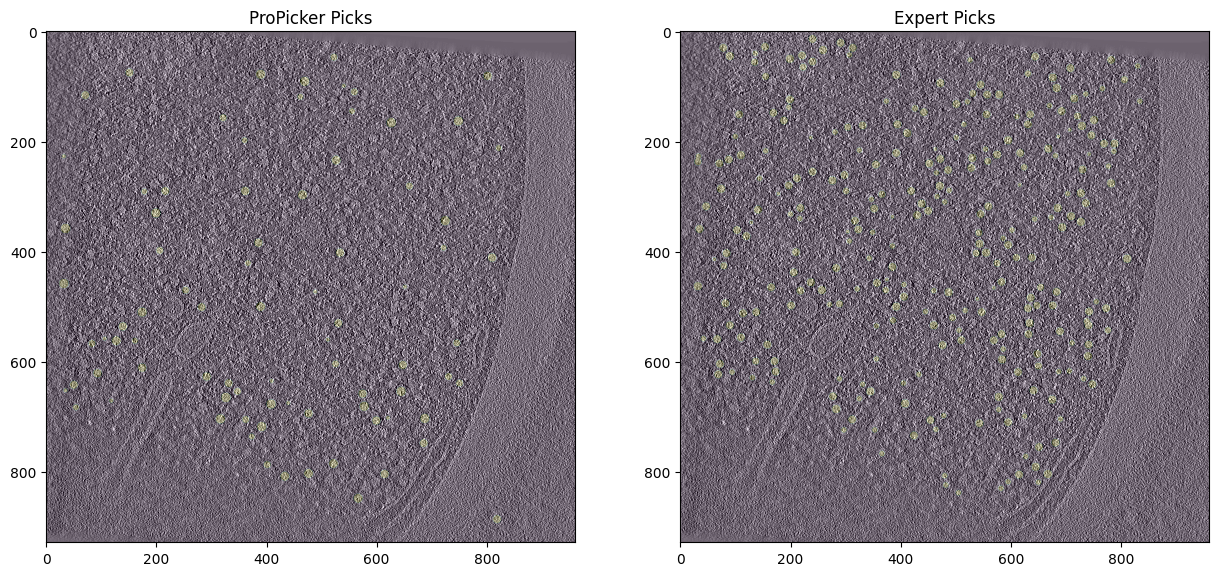

In [42]:
# draw the picked particles as balls
picks = draw_balls(
    positions=cluster_centroids_filt,
    shape=tomo.shape,
    radius=9,
    device=device,
)

# expert picks contained in the dataset
expert_picks = load_mrc_data(f"{EMPIAR10988_BASE_DIR}/labels/{ts_id}_cyto_ribosomes.mrc")[slice_of_interest].bool()


fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
ax[0].set_title("ProPicker Picks")
ax[0].imshow(tomo[100], vmin=-2*tomo.std(), vmax=2*tomo.std(), cmap="gray")
ax[0].imshow(picks[100], alpha=0.15)
ax[1].set_title("Expert Picks")
ax[1].imshow(tomo[100], vmin=-2*tomo.std(), vmax=2*tomo.std(), cmap="gray")
ax[1].imshow(expert_picks[100], alpha=0.15)

## Metric-Based Evaluation of Picks

Computing picking metrics like the F1 score or Precision requires a true-positive criterion.
We use the same one as the authors of TomoTwin, that is, a pick is considered a true positive if a bounding box around is has an intersection-over-union (IoU) of at least 0.6 with a bounding box around and expert pick. 
The bounding box size should be chosen according to the particle size. For the ribosomes, we use a bounding box of 37x37x37 voxels. This true-positive criterion (which we used throughout our paper for consistency) is a bit stricter the one used in the [DeePiCt paper](https://www.nature.com/articles/s41592-022-01746-2), in which the the EMPIAR-10988 dataset was proposed, so we get lower F1 scores.

In [43]:
bbox_size = 37
coords["height"] = coords["width"] = coords["depth"] = bbox_size
cluster_centroids_filt["height"] = cluster_centroids_filt["width"] = cluster_centroids_filt["depth"] = bbox_size

In [44]:
# add class information to the picks so they can be matched with the corresponding expert picks
cluster_centroids_filt["class"] = "cyto_ribosome"

evaluate_picks(
    pred_positions=cluster_centroids_filt,
    gt_positions=coords,
    iou_thresh=0.6,
)

{'cyto_ribosome': {'F1': 0.30738971621241923,
  'Recall': 0.1965504850880345,
  'Precision': 0.7048969072164949,
  'TruePositiveRate': 0.1965504850880345,
  'TP': 547,
  'FP': 229,
  'FN': 2236}}

## Tuning Picking Hyperparameters on Expert Picks

If you have a tomogram with expert picks, you can tune the binarization and size thresholds used for cluster-based picking. This is the best-case F1 which we report in our paper.

In [19]:
get_best_case_cluster_based_picking_performance(
    pred_locmap_dict=pred_locmap_dict,
    optimize_thresh=True, # whether to optimize the binarization threshold
    n_thresh_steps=10,  # how many binarization thresholds to try
    n_size_steps=5,  # how many min and max cluster sizes to try for each binarization threshold
    gt_positions=coords,
    metric="F1",  # you can optimize for "F1", "Precision" or "Recall"
    num_workers=0,
    iou_thresh=0.6,  # a prediction is considered a true positive if the IoU is above this threshold
)       

Running evaluation with 1 workers
Optimizing threshold for cyto_ribosome between 2.0259057423231518e-16 and 0.973297119140625


cyto_ribosome (Best F1: ?.??):   0%|          | 0/250 [00:00<?, ?it/s]

cyto_ribosome (Best F1: 0.35): 100%|██████████| 250/250 [12:38<00:00,  3.03s/it] 


{'cyto_ribosome': {'F1': 0.34920634920634924,
  'Recall': 0.2648221343873518,
  'Precision': 0.5125173852573018,
  'TruePositiveRate': 0.2648221343873518,
  'TP': 737,
  'FP': 701,
  'FN': 2046,
  'min_size': 107.35000000000002,
  'max_size': 17644.75,
  'positions': '          X      Y      Z   size  metric_best  predicted_class  height  width  depth\n0     747.0   39.0    2.0    739          1.0                0      37     37     37\n1     724.0   39.0    4.0   1524          1.0                0      37     37     37\n3     701.0   46.0    8.0   3191          1.0                0      37     37     37\n4     784.0   46.0    5.0   1700          1.0                0      37     37     37\n5     799.0   57.0   25.0  12549          1.0                0      37     37     37\n6     845.0   61.0   30.0   9208          1.0                0      37     37     37\n7     931.0   51.0    3.0    752          1.0                0      37     37     37\n8     881.0   50.0    4.0    219          1

# Conclusion

Prompt-based picking with ProPicker out-of-the-box gives decent results for picking ribosomes in the EMPIAR-10988 dataset. 

For best performance with ProPicker, we recommend fine-tuning the model on labeled data, which the out-of-the-box ProPicker can help you produce. A tutorial on fine-tuning can be found in `fine_tune_empiar10988.ipynb`.